# Finding Donors for Charity 
## Supervised Learning Project

This project will test out several supervised algorithms to accurately model individuals’ income using data collected from the 1994 U.S. Census. We will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. The goal with is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations. Understanding an individual’s income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with. While it can be difficult to determine an individual’s general income bracket directly from public sources, we can infer this value from other publicly available features.

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The dataset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You are welcome to read the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
We will begin with exploratory analysis and loading the data. 

Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import warnings
warnings.filterwarnings('ignore')# This allows to skip warning messages for this ipython notebook

# Import supplementary visualization code visuals.py
import visuals as vs
import seaborn as sns
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


A introductory investigation of the dataset should determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. 
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

In [2]:
#datatypes of this feature
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


In [3]:
# TODO: Total number of records
n_records = len(data)

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == '>50K'])

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == '<=50K'])

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent =  100 * n_greater_50k / n_records

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


In order to view further relationships within the data by different features, counts regarding those that earn above or below 50K a year were provided by sex and educational levels. 

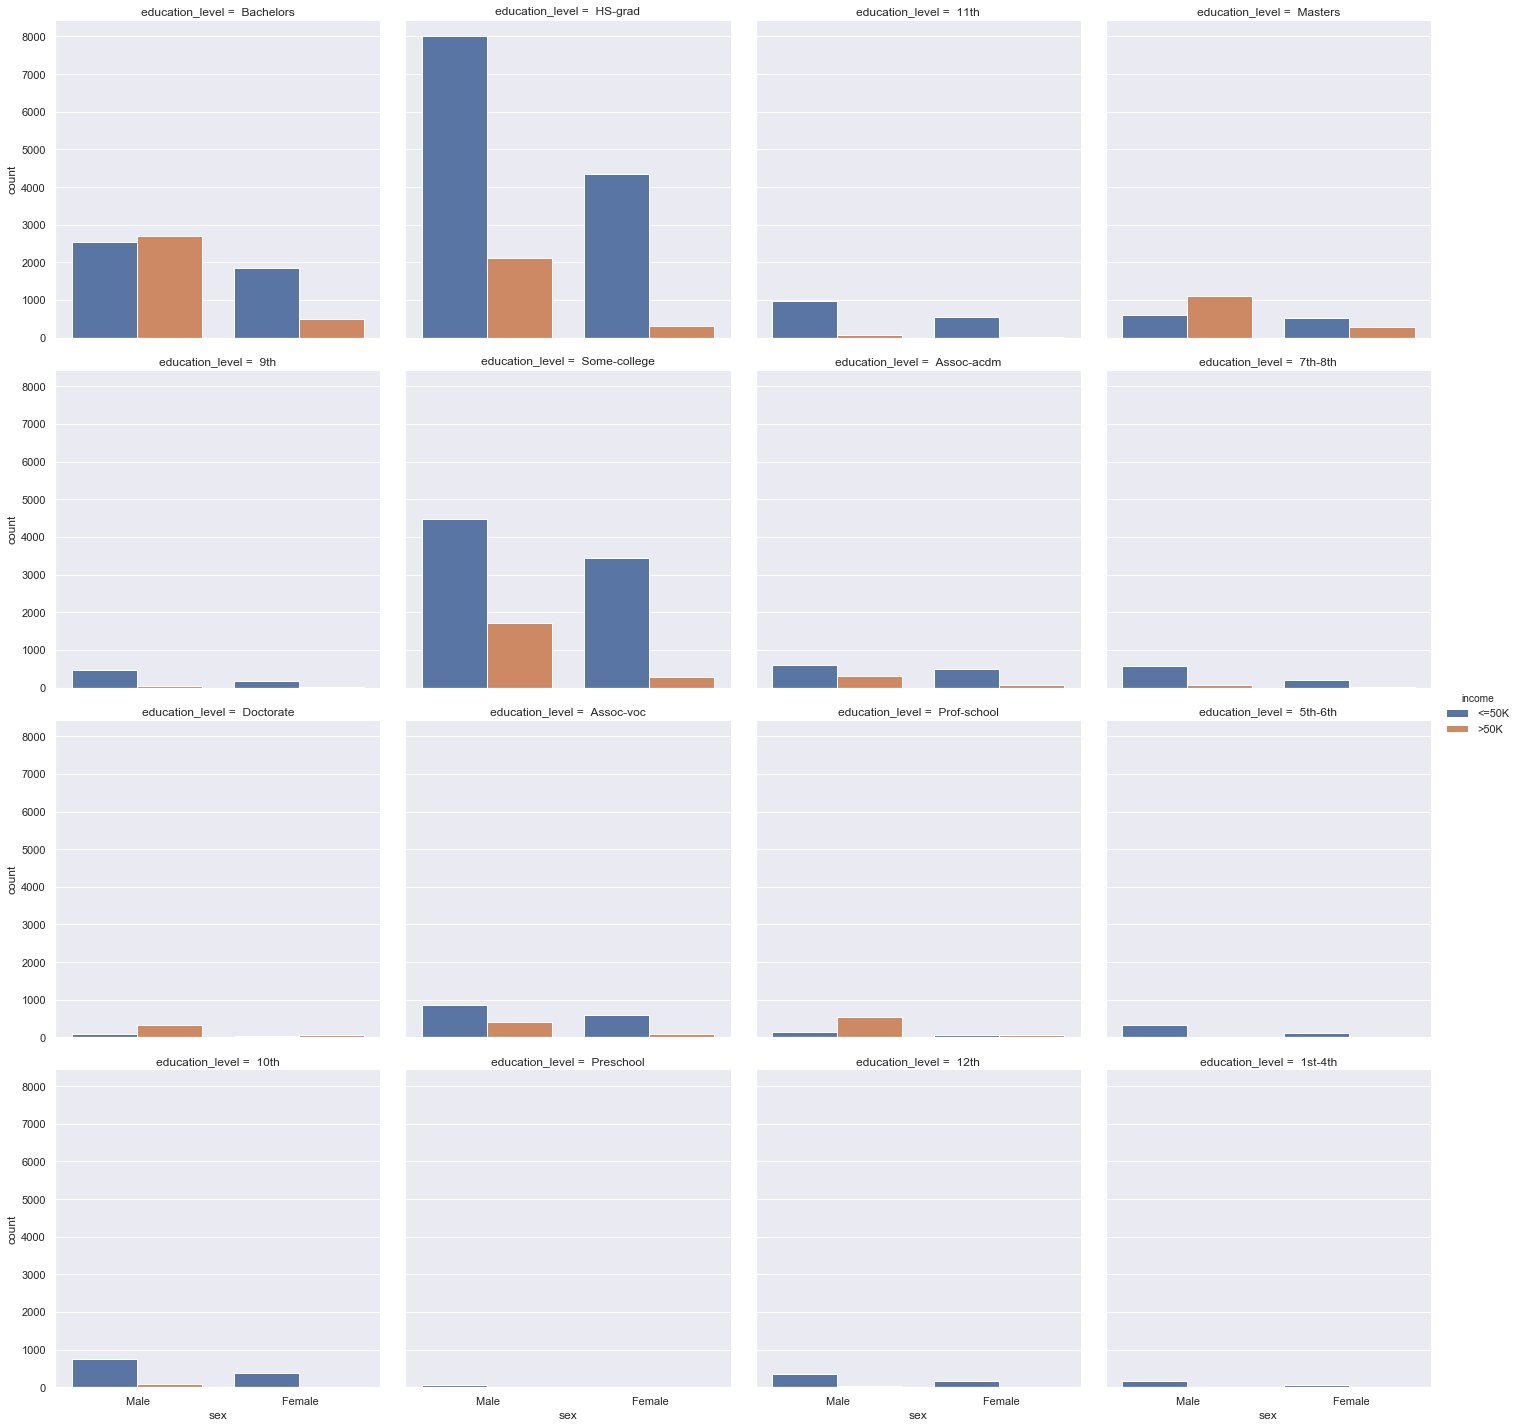

In [4]:
sns.set(style="darkgrid", color_codes=True)
sns.catplot("sex", col='education_level', data=data, hue='income', kind="count", col_wrap=4);

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as preprocessing. Luckily, with this dataset, there are no invalid or missing entries we must deal with- however, there are some qualities about certain features that must be adjusted. 

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

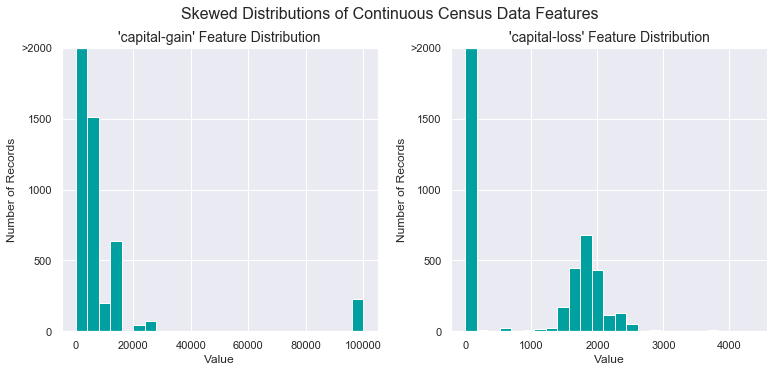

In [6]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)
warnings.filterwarnings('ignore')

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. 

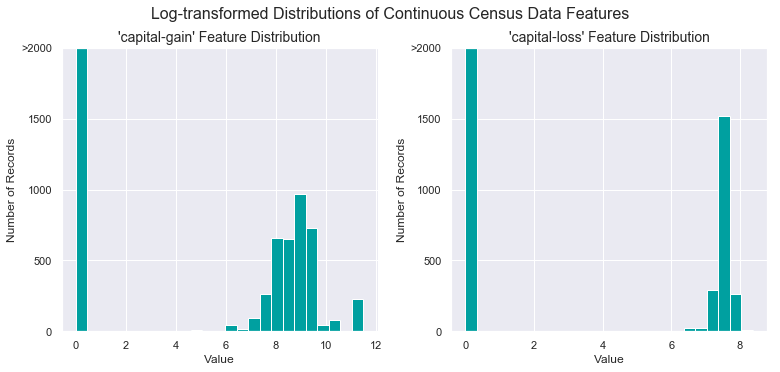

In [7]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))
warnings.filterwarnings('ignore')

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning. 

In [8]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
warnings.filterwarnings('ignore')

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. 

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. 

In [9]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 1 if x == '>50K' else 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing. The 80/20 ratio is a prudent choice in machine learning, referring to [The Pareto Principle](https://en.wikipedia.org/wiki/Pareto_principle).

In [10]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. 

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performance would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for the data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

In [11]:
# TODO: Calculate accuracy, precision and recall
accuracy = n_greater_50k / n_records
recall = n_greater_50k / (n_greater_50k + 0)
precision = n_greater_50k / (n_greater_50k + n_at_most_50k)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1  + (0.5*0.5)) * ( precision * recall / (( 0.5*0.5 * (precision))+ recall))

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Model Application
Here we are exploring different models and their potential to be utilized in this project.


**Decision Trees**

- Real world application: Decision Trees are often used in financial analysis. A particular example of this is for credit card fraud detection. [Reference](http://openaccess.dogus.edu.tr/bitstream/handle/11376/2366/eduman_2011.pdf?sequence=1)
- Strengths:
  Able to handle categorical and numerical data.
  Doesn’t require extensive data pre-processing, and can handle data which has not been normalized, or encoded for Machine 
  Learning Suitability. 
- Weaknesses:
Complex Decision Trees do not generalize well to the data and can result in overfitting.
Unstable, as small variations in the data can result in a different decision tree. This is why they are usually used in an ensemble (Random Forests) to build robustness.
Can create biased trees if some classes dominate others.
- Candidacy: Since a decision tree can handle both numerical and categorical data, it’s a good candidate for this case (although, pre-processing steps may already mitigate advantage we would have had). It’s also easy to interpret, so we will know what happens to interpret the results.

**Support Vector Machines (SVM)**

- Real world application: Example of a real world use of SVMs include image classification and image segmentation. For example: Face detection in an image and classification of proteins in bioinformatics applications. [Reference](https://www.csie.ntu.edu.tw/~p88012/Bio_SVM.pdf)
- Strengths:
  Effective in high dimensional spaces, (computationally efficient) and can handle multiple features.
  Kernel functions can be used to adapt to different cases, and can be completely customized if needed.  SVMs are fairly versatile.
- Weaknesses:
The improper choice of the kernel can negatively affect results. 
Doesn’t directly provide probability estimates.
- Candidacy: SVMs were chosen because of their computational effectiveness given high dimensionality. After incorporating dummy variables, there are more than 100 features in this dataset, so SVMs should be a classifier that works well. 

**Ensemble methods: AdaBoost**

- Real world application: Ensemble methods are used in a variety of ways. A particular example is in biomedical informatics regarding patient outcomes. [Reference](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-015-0723-9)
- Strength:
Ensemble methods, including Adaboost are more robust than single estimators, and can boost the performance of a machine learning model. But however, best used with binary classification models. 
Simple models can be combined to build a complex model, which is computationally fast.
- Weaknesses:
If we have a biased underlying classifier, it will lead to a biased boosted model.
If using complicated "weak learning" models, there is a higher chance of overfitting.
- Candidacy: Ensemble methods are considered to be high quality classifiers, and adaboost is the one of most popular boosting algorithms. 

### Creating a Training and Predicting Pipeline
To properly evaluate the performance of the chosen model, it’s important to create a training and predicting pipeline that allows for quick and effective model training using various sizes of training data and perform predictions on the testing data.

In [12]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    # TODO: Compute F-score on the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Model Evaluation

Now time to train and test the models on training sets. 

DecisionTreeClassifier trained on 362 samples.
DecisionTreeClassifier trained on 3618 samples.
DecisionTreeClassifier trained on 36177 samples.
SVC trained on 362 samples.
SVC trained on 3618 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 362 samples.
AdaBoostClassifier trained on 3618 samples.
AdaBoostClassifier trained on 36177 samples.


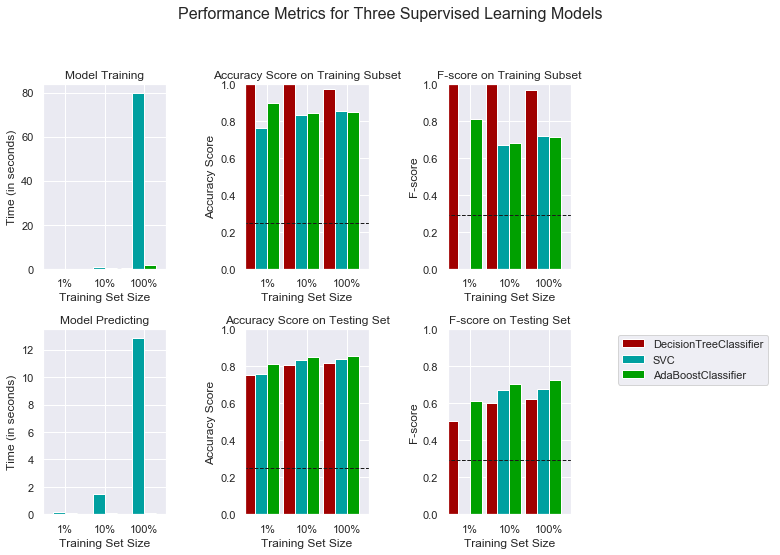

In [13]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
warnings.filterwarnings('ignore')

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier(random_state=101)
clf_B = SVC(random_state = 101)
clf_C = AdaBoostClassifier(random_state = 101)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_1 = int(round(len(X_train) / 100))
samples_10 = int(round(len(X_train) / 10))
samples_100 = len(X_train)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

Looking further into the values by each model. 

In [14]:
#Printing out the values
for i in results.items():
    print (i[0])
    display(pd.DataFrame(i[1]).rename(columns={0:'1%', 1:'10%', 2:'100%'}))

DecisionTreeClassifier


,1%,10%,100%
acc_test,0.753787,0.806081,0.816915
acc_train,1.000000,0.996667,0.970000
f_test,0.505224,0.602673,0.624480
f_train,1.000000,0.997191,0.963855
pred_time,0.015626,0.000000,0.015625
train_time,0.000000,0.031248,0.360604


SVC


,1%,10%,100%
acc_test,0.756219,0.832615,0.837148
acc_train,0.760000,0.833333,0.853333
f_test,0.000000,0.671256,0.674477
f_train,0.000000,0.671296,0.719697
pred_time,0.171872,1.476465,12.842850
train_time,0.015623,0.662143,79.985520


AdaBoostClassifier


,1%,10%,100%
acc_test,0.810282,0.849862,0.857601
acc_train,0.896667,0.840000,0.850000
f_test,0.610253,0.701882,0.724551
f_train,0.811688,0.680147,0.711538
pred_time,0.062499,0.078124,0.062498
train_time,0.062494,0.173913,1.482232


Below, we will use a confusion matrix to visualize the performance of the models chosen. 

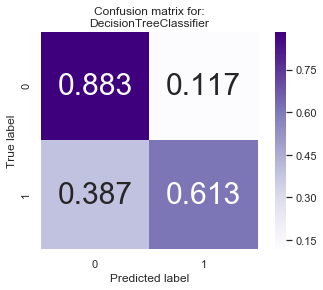

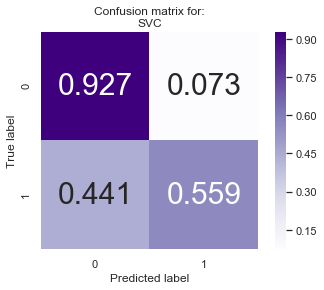

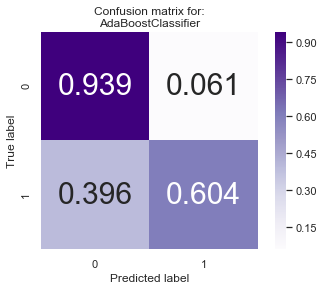

In [15]:
#Visualizing the confusion matrix for each classifier
from sklearn.metrics import confusion_matrix

for i,model in enumerate([clf_A,clf_B,clf_C]):
    cm = confusion_matrix(y_test, model.predict(X_test))
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # normalizing the data

    # view with a heatmap
    plt.figure(i)
    sns.heatmap(cm, annot=True, annot_kws={"size":30}, 
            cmap='Purples', square=True, fmt='.3f')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion matrix for:\n{}'.format(model.__class__.__name__));

In review of the results above, AdaBoost is the best suited for this task out of the three models.

The classifier performs best on the testing data, in terms of both the accuracy and f-score in general. It also takes relatively low time to train on the full dataset (100%), which is a shorter time frame taken by SVM, the next best classifier to train on the full training set (in terms of accuracy and f-score). So it should scale fairly well even if there is more data.

Adaboost uses a decision stump i.e. a decision tree of depth 1 as its base classifier, which can handle categorical and numerical data. Weak learners are relatively faster to train, so the dataset size is not a problem for the algorithm.

### More about Adaboost

Adaboost works by combining several simple learners, to create an ensemble of learners that can predict whether an individual earns above 50k or not.

Each of the learners, (decision tress), are created using “features” we have about individuals  (age, occupation, education, sex, etc) create a set of rules that can predict a person’s income.

During the training process, the Adaboost algorithm looks at instances where it has predicted poorly, and prioritizes the correct prediction of those instances in the next bout of training.

With each bout or pass, the model finds the best learner (decision tree) to incorporate into the ensemble, repeating the process for the specified number of bouts, or until the predictions cannot be improved further.

All the learners are then combined to make a final model, where they each attempt to predict if a person earns more than 50k or not. Usually we take the majority of the votes to make a final prediction.

Using this model with the census information of individuals, we can predict the same information for a potential new donor and predict if they earn more than 50K or not, and subsequently make a decision on the likeliness of them donating to charity.

### Model Tuning
Below GridSearch was used with at least one important parameter tuned with no less than 3 different values-which can help tune the model for better results. 

In [16]:
# TODO: Import 'GridSearchCV', 'make_scorer', etc. 
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import make_scorer
warnings.filterwarnings('ignore')

# TODO: Initialize the classifier
clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {'n_estimators':[50, 100], 
              'learning_rate':[0.1, 0.5, 1.],
              'base_estimator__min_samples_split' : np.arange(2, 8, 2),
              'base_estimator__max_depth' : np.arange(1, 4, 1)
             }
# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, parameters,scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8341
F-score on testing data: 0.6613

Optimized Model
------
Final accuracy score on the testing data: 0.8690
Final F-score on the testing data: 0.7489


### Final Model Evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |      0.8353       |       0.8690    |
| F-score        |      0.6638       |       0.7489    |


The optimized model has an accuracy of 0.8690 and F-score of 0.7489.

These scores are better than the unoptimized model, while being substantially better than the benchmark predictor. Here are the scores that the optimized model is being compared to: Accuracy score: 0.2478, F-score: 0.2917.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.


### Feature Relevance Observation
There are thirteen available features for each individual on record in the census data. Of these thirteen records, we can guess which five features might be most important for prediction. Below I have given my personal shot at this. 

In my opinion, these are most important for prediction:

1. occupation: Different jobs have various pay scales. Some jobs pay higher and lower than others. 
2. education: Those with higher levels of education may earn more due to higher levels of training and/or specialization.
3. age: With age, more wealth can be acquired. 
4. sex: Unfortunately, historically men have earned more than women. 
5. workclass: The working class they belong to can also be correlated with how much money they make.

These are all ranked according the impact I personally feel they have on a person’s income. Occupation is ranked number one as different jobs pay differently. People with higher education are more likely to earn more.

### Extracting Feature Importance

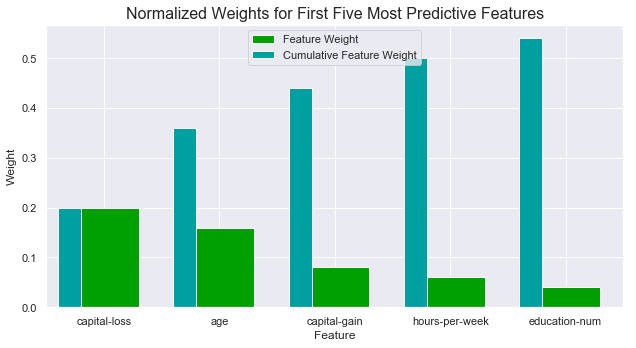

In [17]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier().fit(X_train,y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Extracting Feature Importance

Of the five features predicted in the earlier section, only two of them (age, and  education-num) are included in the list of features considered most important by Adaboost, with different rankings than what I chose.

I did not consider three other important features: capital-gain, capital-loss, and hours-per-week due to not fully understanding these variables (not having much experience with it) and also simply just failing to understand/remember not everyone works full-time. After evaluating the meaning of capital-gain and capital-loss (profit or loss from on the sale of assets/property), it does make sense for these features to be important. Those that have earned profits from sale of assets are definitely likely to earn more (and potentially be in a higher income bracket depending on what type of assets), while those who incurred losses are likely to have had lower income. Those that work full-time will likely earn more overall than those that work part-time. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. 

In [18]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8690
F-score on testing data: 0.7489

Final Model trained on reduced data
------
Accuracy on testing data: 0.8428
F-score on testing data: 0.7008


### Effects of Feature Selection

On a reduced dataset, the final model’s accuracy and f-score are still incredibly similar to the full dataset. 

The accuracy is 2.62% lower, while the f-score is 4.81% lower. Even though Adaboost is relatively faster than one of the other classifiers than the others selected, It would still be beneficial to consider training on the reduced data if training time was a factor, and there are more training points to process. This decision will also depend on how important accuracy and f-scores are (or if f-score is more important than the accuracy, as the dip for that is larger than the dip in accuracy), to make a final decision. 